# Titanic with Xgboost

## Base Process

1. Environment
2. Data Input
3. Feature Engineering
4. Model Build
5. Parameters Opt
6. Else Optimization Method
7. Submit

## Focus Point

1. Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
2. Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
3. Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
4. Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
5. 单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
6. 如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
7. 登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
8. 把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
9. Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。

## Enviroment

In [1]:
#coding:utf-8
## 导入模块以及环境设置
import os,sys,time

import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import feature_selection
from sklearn import model_selection

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
pylab.rcParams['figure.figsize'] = 12,8
sns.set(style="darkgrid")
sns.set_context('talk')

/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Input

In [83]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [84]:
print train_data.info()
print '*'*100
print test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null in

In [93]:
train_data.Cabin.apply(lambda c:'XXX' if pd.isnull(c) else c[0]).value_counts()

XXX    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Cabin, dtype: int64

能够看到Age（float）、Embarked（str）、Fare（float）字段有少量缺失，Cabin（str）字段大量缺失，需要关注一下；

## Feature Engineering

### Data Analysis、Dig、Full、New

简单过滤一下能够得到以下信息：
1. PassengerId基本没用，这个是用于后期test数据检验的，需要后面drop掉。
2. Survived是目标字段。
3. Pclass、Sex、Age是三个最直接的可以直接用于分析的字段。
4. Age由于是数值型，但是有缺失，考虑填充后进行离散化。
5. Name可以根据tital提取出跟年龄相关的数据。
6. SibSp、Parch的作用不敢肯定，表面看有关系，具体要看可视化的结果。
7. Ticket作为票号，规律不知，而且不是纯数值。
8. Fare可以作为Pclass的补充，更加细分，比如同一个Pclass下更贵的可能生存几率更大。
9. Cabin缺失很多，可以考虑生成一个是否存在Cabin的字段观察效果。
10. Embarked可能影响了上船后人们的位置，比如后上船的人可能相对更靠近逃生口？只是猜测，需要验证。

总之，每个字段都需要分析、可视化后，观察跟Survived的关系来决定该字段是丢弃、直接使用、挖掘，还是跟别的字段组合后使用。

In [4]:
survived_ratio = 1.*len(train_data[train_data.Survived==1])/len(train_data)
print '幸存/总人数：'+str(survived_ratio)

幸存/总人数：0.383838383838


由于是不平衡的分类问题，因此考虑添加一个偏差值；

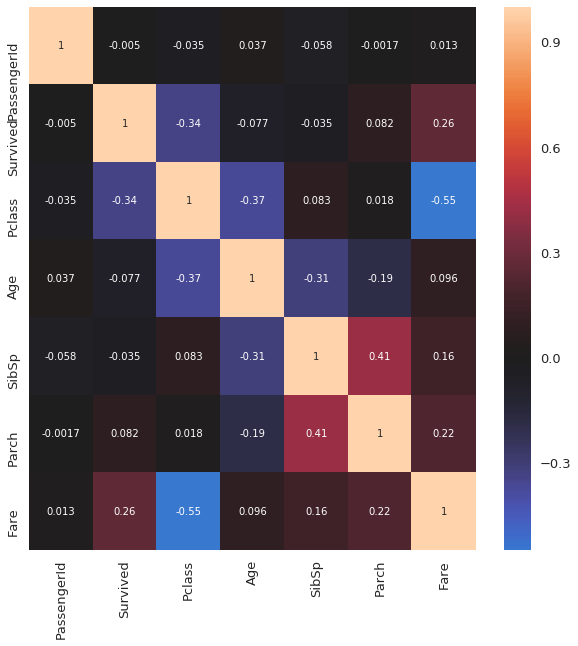

In [5]:
plt.figure(figsize=(10,10))
train_corr = train_data.corr()
sns.heatmap(train_corr, center=0, annot=True)

结论：
- PassengerId与其他字段基本没有相关性，因此直接抛弃不需要分析；
- 目标字段以外的字段没有相关性太高的，也就是冗余的字段，因此先不需要考虑字段合并；
- 与目标字段相关性较高的有Pclass和Fare两个，其余字段原始情况下看相关性不高；

#### Name
分割FamilyName、PersonalName和Title

分割后的好处是可以结合SibSp、Parch来将一些数据作为一个Family整合，也方便后续其他字段集合Name分析。

##### new

In [7]:
train_data['Family_name'] = train_data.Name.apply(lambda n:(n.split(',')[0].strip()))
train_data['Personal_name'] = train_data.Name.apply(lambda n:(n.split(',')[1].split('.')[1].strip()))
train_data['Title'] = train_data.Name.apply(lambda n:(n.split(',')[1].split('.')[0].strip()))

test_data['Family_name'] = test_data.Name.apply(lambda n:(n.split(',')[0].strip()))
test_data['Personal_name'] = test_data.Name.apply(lambda n:(n.split(',')[1].split('.')[1].strip()))
test_data['Title'] = test_data.Name.apply(lambda n:(n.split(',')[1].split('.')[0].strip()))

#### Age

1. 该字段有一定缺失值。
2. Age的影响在于两点：年幼年长的或许可以优先逃生、年轻力壮的生存能力更强。

##### Full

考虑从Title中获取，用具有同一个Title的其他乘客的平均值设置。

In [13]:
train_age_title_map = dict(train_data.groupby(by='Title')['Age'].mean().fillna(20))
test_age_title_map = dict(test_data.groupby(by='Title')['Age'].mean().fillna(20))

In [14]:
def train_full_age(row):
    row['Age'] = row['Age'] if not pd.isnull(row['Age']) else train_age_title_map[row['Title']]
    return row

def test_full_age(row):
    row['Age'] = row['Age'] if not pd.isnull(row['Age']) else test_age_title_map[row['Title']]
    return row

In [15]:
train_data = train_data.apply(train_full_age, axis=1)
test_data = test_data.apply(test_full_age, axis=1)

In [16]:
print 'train data Age has null:'+str(train_data.Age.hasnans)+',test data Age has null:'+str(test_data.Age.hasnans)

train data Age has null:False,test data Age has null:False


##### Dig

In [22]:
age_data = train_data[['Age','Survived', 'Sex']].copy()

In [23]:
for i in range(2,20):
    age_data['Age_'+str(i)] = age_data.Age.apply(lambda a:int(a/i))
# 儿童-6、少年7-14、青年15-35、中年36-60、老年61-
age_data['Age_x'] = age_data.Age.apply(lambda a:0 if a<=6 else (1 if a<=14 else (2 if a<=35 else (3 if a<=60 else 4))))
age_data['Age_y'] = age_data.Age.apply(lambda a:0 if a<=12 else (1 if a<=45 else 2))
age_data['Age_child'] = age_data.Age.apply(lambda a:0 if a<=6 else 1)

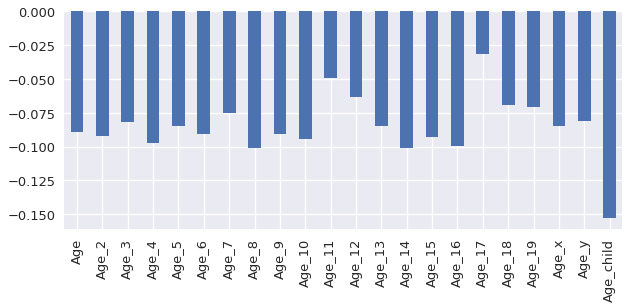

In [24]:
plt.figure(figsize=(10,4))
age_corr = age_data.drop(['Sex', 'Survived'],axis=1).corrwith(age_data.Survived)
age_corr.plot(kind='bar')

从相关性来看，最高的是Age_child，也就是是否是儿童，其次是Age_8，按照步长为8划分的年龄段，均不到-0.2。

尝试加入性别再看看。

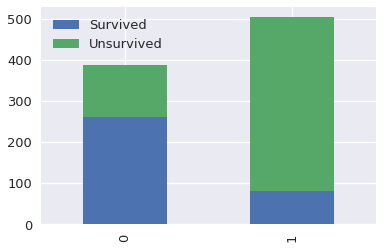

In [25]:
def is_youngman(row):
    row['Is_youngman'] = 1 if row['Age_8']>=2 and row['Age_8']<=6 and row['Sex']=='male' else 0
    return row
age_data = age_data.apply(is_youngman, axis=1)
Survived_0 = age_data.Is_youngman[age_data.Survived == 0].value_counts()
Survived_1 = age_data.Is_youngman[age_data.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1, u'Unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)

这一属性用于区分16~48内的男性与其他的对比关系，虽然相关性看着比较高，但是更多应该是sex带来的。

In [27]:
print 'Is_youngman corr with Survived:'+str(age_data.Is_youngman.corr(age_data.Survived))

Is_youngman corr with Survived:-0.516985258962


##### new

In [28]:
train_data['Age_8'] = train_data.Age.apply(lambda a:int(a/8))
test_data['Age_8'] = test_data.Age.apply(lambda a:int(a/8))

train_data['Is_child'] =train_data.Age.apply(lambda a:1 if a<=6 else 0)
test_data['Is_child'] = test_data.Age.apply(lambda a:1 if a<=6 else 0)

train_data = train_data.apply(is_youngman, axis=1)
test_data = test_data.apply(is_youngman, axis=1)

#### Sex

毫无疑问，性别是一个非常重要的属性，并且它是完成的，没有nan值，nice。

PS:0 for male, 1 for female

In [29]:
sex_data = train_data[['Sex','Pclass','Survived']].copy()

##### Dig

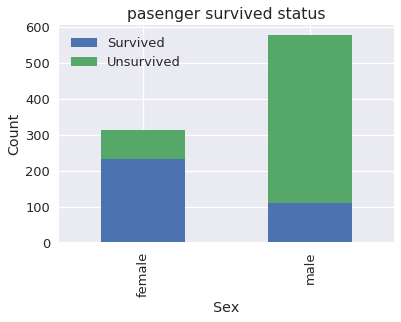

In [30]:
Survived_0 = sex_data.Sex[sex_data.Survived == 0].value_counts()
Survived_1 = sex_data.Sex[sex_data.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1, u'Unsurvived':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Sex") 
plt.ylabel(u"Count") 

可以看到，女性幸存率远远高于男性，同时女性总人数要少于男性；

结合Pclass来看呢。

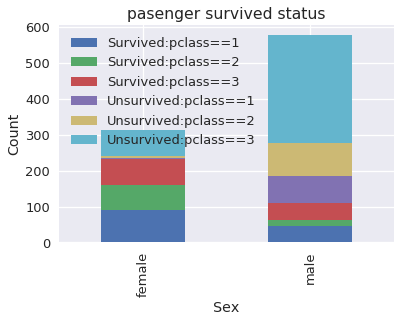

In [32]:
Survived_0_pclass1 = sex_data.Sex[sex_data.Pclass==1][sex_data.Survived==0].value_counts()
Survived_0_pclass2 = sex_data.Sex[sex_data.Pclass==2][sex_data.Survived==0].value_counts()
Survived_0_pclass3 = sex_data.Sex[sex_data.Pclass==3][sex_data.Survived==0].value_counts()
Survived_1_pclass1 = sex_data.Sex[sex_data.Pclass==1][sex_data.Survived==1].value_counts()
Survived_1_pclass2 = sex_data.Sex[sex_data.Pclass==2][sex_data.Survived==1].value_counts()
Survived_1_pclass3 = sex_data.Sex[sex_data.Pclass==3][sex_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived:pclass==1':Survived_1_pclass1,
                 u'Survived:pclass==2':Survived_1_pclass2,
                 u'Survived:pclass==3':Survived_1_pclass3,
                 u'Unsurvived:pclass==1':Survived_0_pclass1,
                 u'Unsurvived:pclass==2':Survived_0_pclass2,
                 u'Unsurvived:pclass==3':Survived_0_pclass3,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Sex") 
plt.ylabel(u"Count") 

可以看到，pclass为2,3的男性乘客的幸存率很低，而pclass为1,2的女性乘客则非常高，可以利用这两个特点。

##### new

In [33]:
def new_female_pclass12(row):
    row['Is_female_pclass1'] = 1 if(row['Sex']=='female' and row['Pclass'] in [1]) else 0
    row['Is_female_pclass2'] = 1 if(row['Sex']=='female' and row['Pclass'] in [2]) else 0
    row['Is_female_pclass3'] = 1 if(row['Sex']=='female' and row['Pclass'] in [3]) else 0
    return row

def new_male_pclass23(row):
    row['Is_male_pclass1'] = 1 if(row['Sex']=='male' and row['Pclass'] in [1]) else 0
    row['Is_male_pclass2'] = 1 if(row['Sex']=='male' and row['Pclass'] in [2]) else 0
    row['Is_male_pclass3'] = 1 if(row['Sex']=='male' and row['Pclass'] in [3]) else 0
    return row

In [34]:
train_data = train_data.apply(new_female_pclass12, axis=1)
test_data = test_data.apply(new_female_pclass12, axis=1)

train_data = train_data.apply(new_male_pclass23, axis=1)
test_data = test_data.apply(new_male_pclass23, axis=1)

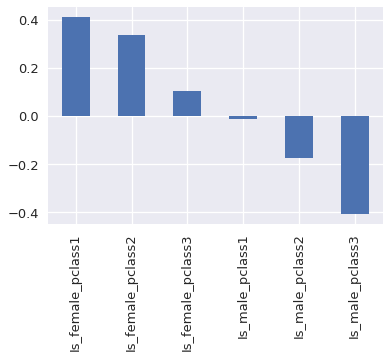

In [35]:
train_data[['Is_female_pclass1','Is_female_pclass2','Is_female_pclass3',
            'Is_male_pclass1','Is_male_pclass2','Is_male_pclass3']].corrwith(train_data.Survived).plot(kind='bar')

男性一级船票与目标几乎没有相关性，说明这种的乘客生存几乎一半一半，而female&1、female&2、male&3相关性非常大；

#### Pclass

之前的热图可以看到Pclass跟Survived的相关性有-0.34，非常高了，说明船舱等级同样对与是否幸存影响很大。

##### Dig

In [36]:
pclass_data = train_data[['Pclass','Fare','Survived','Sex']].copy()

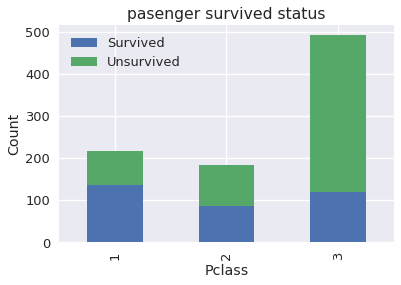

In [37]:
Survived_0 = pclass_data.Pclass[pclass_data.Survived==0].value_counts()
Survived_1 = pclass_data.Pclass[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Pclass") 
plt.ylabel(u"Count") 

非常明显的差异表现，更高级的船舱对应更高的幸存率。

我们知道虽然Pclass有3个级别，但是对应应该有更多的细分，比如是否靠窗、是否有独立卫生间等等，因此结合Fare细分处理。

将原本的Pclass:1,2,3细分为11,12,13,21,22,23,31,32,33

In [49]:
quantile_1_25 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.25)
quantile_1_50 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.5)
quantile_1_75 = pclass_data[pclass_data.Pclass==1].Fare.quantile(0.75)
quantile_1_100 = pclass_data[pclass_data.Pclass==1].Fare.quantile(1)

quantile_2_25 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.25)
quantile_2_50 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.5)
quantile_2_75 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.75)
quantile_2_100 = pclass_data[pclass_data.Pclass==2].Fare.quantile(1)

quantile_3_25 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.25)
quantile_3_50 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.5)
quantile_3_75 = pclass_data[pclass_data.Pclass==2].Fare.quantile(0.75)
quantile_3_100 = pclass_data[pclass_data.Pclass==2].Fare.quantile(1)

quantiles = [[quantile_1_25,quantile_1_50,quantile_1_75,quantile_1_100],
             [quantile_2_25,quantile_2_50,quantile_2_75,quantile_2_100],
             [quantile_3_25,quantile_3_50,quantile_3_75,quantile_3_100]]

def pclass_x(row):
    pclass = int(row['Pclass'])
    fare = row['Fare']
    #row['Pclass_x'] = 10*pclass+(1 if fare<=quantiles[pclass-1][0] else (2 if fare<=quantiles[pclass-1][1] else (3 if fare<=quantiles[pclass-1][2] else 4)))
    row['Pclass_x'] = 10*pclass+(1 if fare<=quantiles[pclass-1][1] else (2 if fare<=quantiles[pclass-1][2] else 3))
    row['Pclass_y'] = 0 if row['Pclass_x'] in [12,13,21,31,33] else 1
    #row['Pclass_sex'] = 10*pclass+row['Sex']
    return row

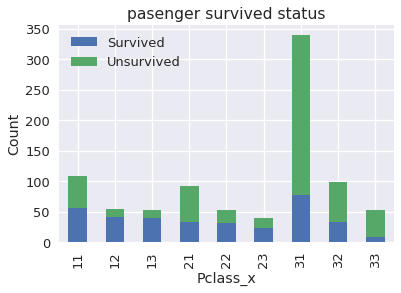

In [50]:
pclass_data = pclass_data.apply(pclass_x, axis=1)

Survived_0 = pclass_data.Pclass_x[pclass_data.Survived==0].value_counts()
Survived_1 = pclass_data.Pclass_x[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Pclass_x") 
plt.ylabel(u"Count")

可以看到：
- 对于Pclass==1：2和3高于1；
- 对于Pclass==2：2和3高于1；
- 对于Pclass==3：也类似是有这样的规律，是否可以理解为细分的2和3的位置利于逃生呢；

再看看相关性。

In [51]:
print 'Pclass_x corr Survived:'+str(pclass_data.Pclass_x.corr(pclass_data.Survived))

Pclass_x corr Survived:-0.327821005371


略高于Pclass，可以使用。

##### new

In [53]:
train_data = train_data.apply(pclass_x, axis=1)
test_data = test_data.apply(pclass_x, axis=1)

#### SibSp & Parch

整合一个家庭人数字段看看效果如何。

##### Dig

In [54]:
family_data = train_data[['SibSp','Parch','Survived']].copy()

In [58]:
def familys(row):
    row['Family'] = row['SibSp']+row['Parch']+1
    row['Family'] = row['Family'] if row['Family']<=4 else 5
    return row

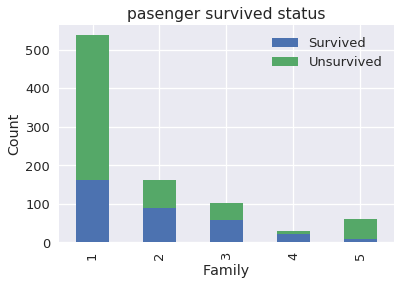

In [59]:
family_data = family_data.apply(familys, axis=1)

Survived_0 = family_data.Family[pclass_data.Survived==0].value_counts()
Survived_1 = family_data.Family[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Family") 
plt.ylabel(u"Count")

可以看到，还是有一些影响的，相对而言，家人多的幸存几率更大，再看看相关系数。

In [60]:
print 'Family corr Survived:'+str(family_data.Family.corr(family_data.Survived))

Family corr Survived:0.079794802632


很不错的相关系数，再看看是否独自一人对幸存的影响。

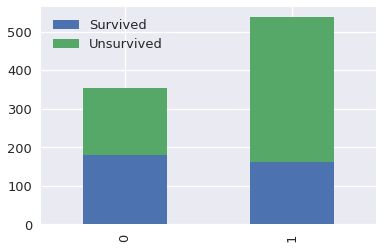

In [61]:
family_data['Is_alone'] = family_data.Family.apply(lambda f:1 if f<=1 else 0)

Survived_0 = family_data.Is_alone[pclass_data.Survived==0].value_counts()
Survived_1 = family_data.Is_alone[pclass_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)

In [62]:
print 'Family corr Survived:'+str(family_data.Is_alone.corr(family_data.Survived))

Family corr Survived:-0.2033670857


##### new

In [63]:
train_data = train_data.apply(familys, axis=1)
test_data = test_data.apply(familys, axis=1)

train_data['Is_alone'] = train_data.Family.apply(lambda f:1 if f<=1 else 0)
test_data['Is_alone'] = test_data.Family.apply(lambda f:1 if f<=1 else 0)

#### Fare

票价分析同年龄分析，划分上使用分位数。本身Fare具有0.26的相关性，也是很高的。

##### full

In [64]:
train_data.Fare.fillna(train_data.Fare.mean(), inplace=True)
test_data.Fare.fillna(test_data.Fare.mean(), inplace=True)

##### Dig

In [65]:
fare_data = train_data[['Fare','Survived']].copy()

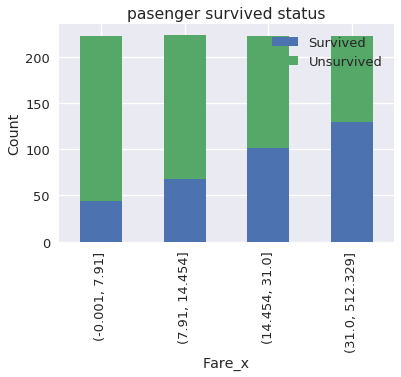

In [66]:
fare_data['Fare_x'] = pd.qcut(fare_data['Fare'], 4)

Survived_0 = fare_data.Fare_x[fare_data.Survived==0].value_counts()
Survived_1 = fare_data.Fare_x[fare_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)
plt.title(u"pasenger survived status")
plt.xlabel(u"Fare_x") 
plt.ylabel(u"Count")

看到票价越高，幸存比例越大，这根Pclass也是吻合的，这二者应该是存在信息上的冗余的；

##### new

In [67]:
train_data['Fare_x'] = pd.qcut(train_data['Fare'], 4)
test_data['Fare_x'] = pd.qcut(test_data['Fare'], 4)

#### Cabin

由于Cabin存在大量缺失值，且缺失原因不明，因此不能填充它，但是我们可以考虑根据是否缺失这一特点来可视化一下。

In [68]:
cabin_data = train_data[['Cabin','Survived']].copy()

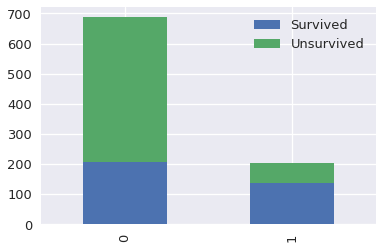

In [69]:
cabin_data['Has_cabin'] = cabin_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)

Survived_0 = cabin_data.Has_cabin[cabin_data.Survived==0].value_counts()
Survived_1 = cabin_data.Has_cabin[cabin_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)

可以看到，具有Cabin值的乘客中，大部分都幸存了，这个不确定原因，但是不妨碍我们使用这一特征。

##### new

In [70]:
train_data['Has_cabin'] = train_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)
test_data['Has_cabin'] = test_data.Cabin.apply(lambda c:0 if pd.isnull(c) else 1)

#### Embarked

这一属性本身具有0.11的相关性，实际考虑可能登船顺序跟船舱位置有关。

##### Full

In [71]:
# 使用数量最多的S填充
train_data.Embarked.fillna('S', inplace=True)
test_data.Embarked.fillna('S', inplace=True)

##### Dig

In [72]:
embarked_data = train_data[['Embarked', 'Survived']].copy()

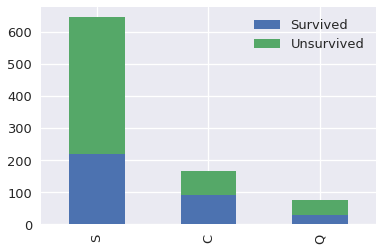

In [73]:
Survived_0 = embarked_data.Embarked[embarked_data.Survived==0].value_counts()
Survived_1 = embarked_data.Embarked[embarked_data.Survived==1].value_counts()
df=pd.DataFrame({u'Survived':Survived_1,
                 u'Unsurvived':Survived_0,})
df.plot(kind='bar', stacked=True)

可以看到，数据非常不平衡，因此暂不考虑此字段。

### Useless Feature Drop

当前字段有：

In [74]:
train_data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Family_name', u'Personal_name', u'Title', u'Age_8', u'Is_child',
       u'Is_youngman', u'Is_female_pclass1', u'Is_female_pclass2',
       u'Is_female_pclass3', u'Is_male_pclass1', u'Is_male_pclass2',
       u'Is_male_pclass3', u'Pclass_x', u'Pclass_y', u'Family', u'Is_alone',
       u'Fare_x', u'Has_cabin'],
      dtype='object')

#### 丢弃前暂存后续有用的字段

In [75]:
target_data = train_data.Survived.copy()
passengerId_data = test_data.PassengerId.copy()

#### 分析可丢弃的字段

1. PassengerId:只在上传kaggle时有用。
2. Survived:目标字段需要丢弃。
3. Name、Family_name、Personal_name:名字相关。
4. Ticket:不知道咋用。
5. Age:被Age_8代替。
6. SibSp、Parch:被Family、Is_alone代替。
7. Fare:被Fare_x代替。
8. Pclass:被Pclass_x代替。

In [76]:
drop_list = ['PassengerId', 'Name', 'Family_name', 'Personal_name', 
             'Cabin', 'Ticket', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass']

train_data.drop(drop_list, axis=1, inplace=True)
test_data.drop(drop_list, axis=1, inplace=True)

#### 最终热图

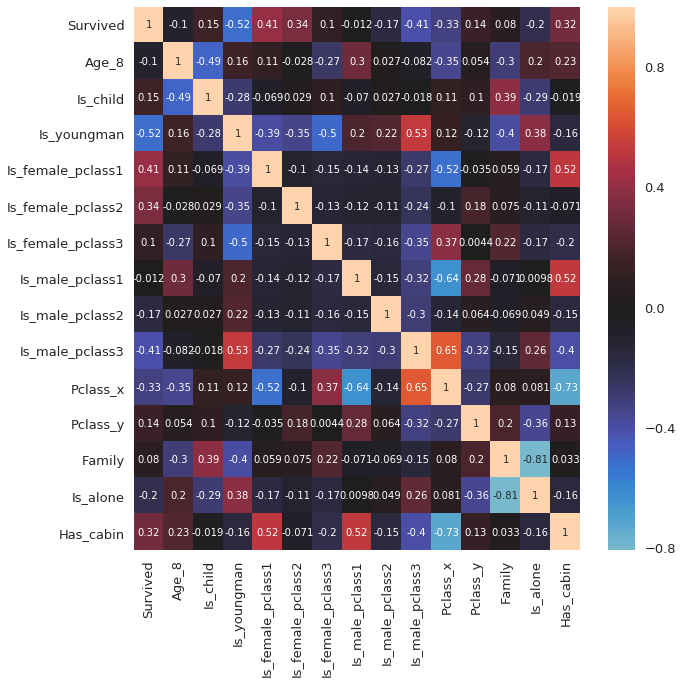

In [77]:
plt.figure(figsize=(10,10))
train_corr = train_data.corr()
sns.heatmap(train_corr, center=0, annot=True)

#### 丢弃Survived

In [78]:
train_data.drop(['Survived'], axis=1, inplace=True)

## Data Process

### 字符mapping到数值

由于很多计算都需要数值型数据，因此将个别字符型mapping到数值上。

In [80]:
label = LabelEncoder()
for dataset in [train_data,test_data]:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['Fare_Code'] = label.fit_transform(dataset['Fare_x'])
    
train_data.drop(['Sex','Embarked','Title','Fare_x'], axis=1, inplace=True)
test_data.drop(['Sex','Embarked','Title','Fare_x'], axis=1, inplace=True)

In [81]:
train_data.columns

Index([u'Age_8', u'Is_child', u'Is_youngman', u'Is_female_pclass1',
       u'Is_female_pclass2', u'Is_female_pclass3', u'Is_male_pclass1',
       u'Is_male_pclass2', u'Is_male_pclass3', u'Pclass_x', u'Pclass_y',
       u'Family', u'Is_alone', u'Has_cabin', u'Sex_Code', u'Embarked_Code',
       u'Title_Code', u'Fare_Code'],
      dtype='object')

### PCA

pca = PCA(n_components=5).fit(train_data)
print 'explained_variance_ratio:'+str(pca.explained_variance_ratio_)
print 'sum pca.explained_variance_ratio_:'+str(sum(pca.explained_variance_ratio_))

train_data = pd.DataFrame(pca.transform(train_data))
test_data = pd.DataFrame(pca.transform(test_data))

## Model Build

In [53]:
# 构建所有待测试的模型实例，参数都是默认
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train_data, target_data, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    #alg.fit(train_data, target_data)
    #MLA_predict[MLA_name] = alg.predict(train_data)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/kael/Software/anaconda2/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytre...",0.857865,0.824627,0.0682744,0.0204056
3,GradientBoostingClassifier,"{'presort': 'auto', 'loss': 'deviance', 'min_i...",0.87191,0.81791,0.0680538,0.0529069
6,LogisticRegressionCV,"{'scoring': None, 'n_jobs': 1, 'verbose': 0, '...",0.831273,0.81791,0.0421229,0.201841
0,AdaBoostClassifier,"{'n_estimators': 50, 'base_estimator': None, '...",0.835581,0.817537,0.0754996,0.0969837
14,SVC,"{'kernel': 'rbf', 'C': 1.0, 'verbose': False, ...",0.840449,0.816418,0.0600317,0.0460294
2,ExtraTreesClassifier,"{'warm_start': False, 'oob_score': False, 'n_j...",0.919476,0.814925,0.0579933,0.0202605
8,RidgeClassifierCV,"{'normalize': False, 'alphas': (0.1, 1.0, 10.0...",0.831086,0.813806,0.0408083,0.00232277
19,LinearDiscriminantAnalysis,"{'solver': 'svd', 'priors': None, 'n_component...",0.831461,0.812313,0.0472409,0.00171828
15,NuSVC,"{'kernel': 'rbf', 'verbose': False, 'probabili...",0.833146,0.810448,0.0791221,0.0552248
4,RandomForestClassifier,"{'warm_start': False, 'oob_score': False, 'n_j...",0.91236,0.808582,0.073923,0.0213416


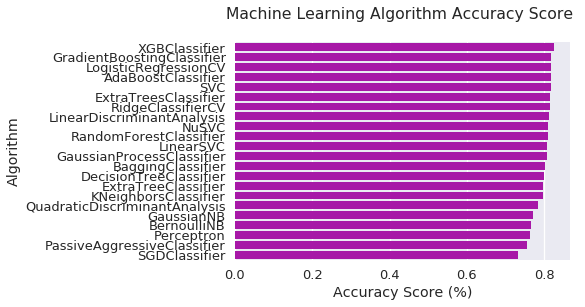

In [54]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [55]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_data, target_data, cv= cv_split)
vote_hard.fit(train_data, target_data)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('*'*100)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_data, target_data, cv  = cv_split)
vote_soft.fit(train_data, target_data)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('*'*100)

Hard Voting Training w/bin score mean: 87.55
Hard Voting Test w/bin score mean: 82.46
Hard Voting Test w/bin score 3*std: +/- 5.48
----------
Soft Voting Training w/bin score mean: 88.73
Soft Voting Test w/bin score mean: 81.90
Soft Voting Test w/bin score 3*std: +/- 4.48
----------


## Submit

In [56]:
y_hat = vote_soft.predict(test_data)
pd.DataFrame({'PassengerId':list(passengerId_data), 'Survived':y_hat}).to_csv('submission_mlax.csv', index=False)

#### 得分情况

* 第一次：排名7288 in 9,879 teams，得分0.76555，Top 74%。

## 记录

1. 第一版：模型在valid上的得分最终为0.843575418994。
2. 第二版：对base_score修正为0.383838，在valid上最终得分为0.849162011173。
3. 第三版：增加Is_youngman字段，在valid上最终得分为0.793296089385，说明这一特征的加入起到的负面影响更大，先去掉吧。
4. 第四版：增加了多模型融合，对测试集、验证集有提升，但是提交kaggle得分没变。
5. 第五版：增加PCA，目前应该是存在数据维度较高问题的。
6. 第六版：选择不同的算法得到的不同模型进行融合，而不仅仅是使用xgboost。

## Knowledge Point

1. mapping操作：将字符型字段的每个取值都映射到一个数字上，可以使用LabelEnconder。
2. age等的离散化操作：可以使用pd.qcut、pd.cut来实现:
    * qcut是根据这些值的频率来选择箱子的均匀间隔，即每个箱子中含有的数的数量是相同的
    * cut将根据值本身来选择箱子均匀间隔，即每个箱子的间距都是相同的
3. 根据条件对一列中的某些位置赋值：dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0。
4. 多模型举手表决：ensemble.VotingClassifier。
5. 多模型对比：model build部分，将结果拼接到一个DataFrame方便可视化。